In [ ]:
import matplotlib
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Liberation Serif'
# plt.rcParams['font.family'] = 'Liberation Serif Bold'
from matplotlib.font_manager import FontProperties
print("Current font:", FontProperties().get_name())

In [5]:
import numpy as np
import numpy.polynomial.polynomial as poly

# ------------------------------
# Data preparation
# ------------------------------
R = 8.5  # Rotor radius

# Inflow velocity U0 (20 rows)
U0_list = np.array([
    0.4, 0.6, 0.756, 0.8, 0.81, 0.9, 1.0, 1.1, 1.2, 1.3,
    1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.5, 3.0, 4.0
], dtype=float)

# Angular velocity ω (7 columns)
omega_list = np.array([
    0.800, 0.817, 1.055, 1.067, 1.100, 1.260, 1.400
], dtype=float)

# Total Moment (kNm) matrix (20x7)
moment_matrix = np.array([
    [-60.98, -41.95, -92.01, -94.84, -102.69, -143.16, -182.06],
    [-53.71, -56.73, -104.13, -106.81, -114.30, -154.24, -191.21],
    [-42.25, -45.38,  -95.08,  -97.85, -105.60, -145.53, -184.44],
    [-38.79, -41.95,  -92.01,  -94.85, -102.69, -143.16, -182.06],
    [-37.90, -41.05,  -91.21,  -94.02, -101.89, -142.51, -181.42],
    [-29.40, -32.52,  -83.32,  -86.21,  -94.21, -135.74, -175.57],
    [-19.46, -22.47,  -73.03,  -75.93,  -84.03, -126.38, -167.22],
    [ -9.88, -12.52,  -61.37,  -64.29,  -72.48, -115.37, -156.86],
    [ -0.15,  -2.83,  -48.74,  -51.61,  -59.72, -102.88, -144.96],
    [  8.77,   6.79,  -35.68,  -38.41,  -46.28,  -88.99, -131.43],
    [ 15.85,  13.64,  -22.63,  -25.12,  -32.57,  -74.07, -116.54],
    [ 22.31,  21.21,  -10.31,  -12.94,  -19.19,  -58.62, -100.43],
    [ 27.50,  26.89,    1.91,    0.67,   -6.65,  -42.87,  -83.52],
    [ 32.33,  32.01,   13.98,   12.68,    5.59,  -27.52,  -66.25],
    [ 36.73,  36.67,   22.87,   22.47,   18.38,  -12.79,  -48.82],
    [ 40.79,  40.93,   32.97,   31.92,   26.51,    1.30,  -31.63],
    [ 44.31,  44.72,   40.88,   40.30,   37.84,   17.07,  -15.18],
    [ 58.45,  59.67,   71.17,   71.33,   71.58,   68.03,   57.29],
    [ 74.19,  75.03,   92.41,   93.31,   95.52,  102.40,  102.86],
    [112.11, 113.43,  131.28,  132.22,  134.54,  148.75,  164.40]
], dtype=float)

# ------------------------------
# Helper function: linear interpolation
# ------------------------------
def find_zero_linear(x_vals, y_vals):
    """
    For 1D data (x_vals, y_vals), use linear interpolation to find zero crossings of y.
    Return all zero points within the range [min, max].
    """
    zero_points = []
    for i in range(len(x_vals)-1):
        x1, x2 = x_vals[i], x_vals[i+1]
        y1, y2 = y_vals[i], y_vals[i+1]
        if y1 * y2 < 0:
            x0 = x1 + (x2 - x1)*(-y1)/(y2 - y1)
            zero_points.append(x0)
    return zero_points

# ------------------------------
# Helper function: quadratic interpolation using polynomial fit
# ------------------------------
def find_zero_by_polyfit(x_vals, y_vals, deg=2):
    """
    Fit a polynomial of degree 'deg' to (x_vals, y_vals),
    find all real roots where y=0,
    return those within [min(x_vals), max(x_vals)].
    """
    coefs = poly.polyfit(x_vals, y_vals, deg=deg)
    roots = poly.polyroots(coefs)
    real_roots = []
    x_min, x_max = np.min(x_vals), np.max(x_vals)
    for r in roots:
        if np.isreal(r):
            xr = r.real
            if x_min <= xr <= x_max:
                real_roots.append(xr)
    return real_roots

# ------------------------------
# 1. Row-wise interpolation (fixed U0, x = ω)
# ------------------------------

row_linear_TSRs = []   # TSRs by linear interpolation (row-wise)
row_poly_TSRs   = []   # TSRs by polynomial interpolation (row-wise)

print("=== Row-wise interpolation results (fixed U0):")
for i, U0 in enumerate(U0_list):
    M_row = moment_matrix[i, :]
    zeros_linear = find_zero_linear(omega_list, M_row)
    zeros_poly = find_zero_by_polyfit(omega_list, M_row, deg=2)

    if zeros_linear:
        omega_linear = np.mean(zeros_linear)
        TSR_linear = (omega_linear * R) / U0
        row_linear_TSRs.append(TSR_linear)
        print(f"U0={U0:.3f} m/s, Linear interpolation: ω0_avg={omega_linear:.4f} rad/s, TSR={TSR_linear:.4f}")
    else:
        print(f"U0={U0:.3f} m/s, Linear interpolation: No zero crossing")

    if zeros_poly:
        omega_poly = np.mean(zeros_poly)
        TSR_poly = (omega_poly * R) / U0
        row_poly_TSRs.append(TSR_poly)
        print(f"                Polynomial interpolation: ω0_avg={omega_poly:.4f} rad/s, TSR={TSR_poly:.4f}")
    else:
        print(f"                Polynomial interpolation: No zero crossing")

# ------------------------------
# 2. Column-wise interpolation (fixed ω, x = U0)
# ------------------------------

col_linear_TSRs = []   # TSRs by linear interpolation (column-wise)
col_poly_TSRs   = []   # TSRs by polynomial interpolation (column-wise)

print("\n=== Column-wise interpolation results (fixed ω):")
for j, w in enumerate(omega_list):
    M_col = moment_matrix[:, j]
    zeros_linear = find_zero_linear(U0_list, M_col)
    zeros_poly = find_zero_by_polyfit(U0_list, M_col, deg=2)

    if zeros_linear:
        U0_linear = np.mean(zeros_linear)
        TSR_linear = (w * R) / U0_linear
        col_linear_TSRs.append(TSR_linear)
        print(f"ω={w:.3f} rad/s, Linear interpolation: U0*_avg={U0_linear:.4f} m/s, TSR={TSR_linear:.4f}")
    else:
        print(f"ω={w:.3f} rad/s, Linear interpolation: No zero crossing")

    if zeros_poly:
        U0_poly = np.mean(zeros_poly)
        TSR_poly = (w * R) / U0_poly
        col_poly_TSRs.append(TSR_poly)
        print(f"    Polynomial interpolation: U0*_avg={U0_poly:.4f} m/s, TSR={TSR_poly:.4f}")
    else:
        print(f"    Polynomial interpolation: No zero crossing")

# ------------------------------
# 3. Calculate mean and variance
# ------------------------------
def print_stats(data, label):
    data_arr = np.array(data)
    mean_val = np.mean(data_arr)
    var_val = np.var(data_arr)
    std_val = np.std(data_arr)
    print(f"{label}: Mean = {mean_val:.4f}, Variance = {var_val:.4f}, Std Dev = {std_val:.4f}")
    return std_val

print("\n=== Statistics ===")
print("Row-wise (fixed U0):")
row_linear_std, row_poly_std = None, None
if row_linear_TSRs:
    row_linear_std = print_stats(row_linear_TSRs, "  Linear interpolation TSR")
else:
    print("  Linear interpolation TSR data is empty")

if row_poly_TSRs:
    row_poly_std = print_stats(row_poly_TSRs, "  Polynomial interpolation TSR")
else:
    print("  Polynomial interpolation TSR data is empty")

print("\nColumn-wise (fixed ω):")
col_linear_std, col_poly_std = None, None
if col_linear_TSRs:
    col_linear_std = print_stats(col_linear_TSRs, "  Linear interpolation TSR")
else:
    print("  Linear interpolation TSR data is empty")

if col_poly_TSRs:
    col_poly_std = print_stats(col_poly_TSRs, "  Polynomial interpolation TSR")
else:
    print("  Polynomial interpolation TSR data is empty")


=== Row-wise interpolation results (fixed U0):
U0=0.400 m/s, Linear interpolation: No zero crossing
                Polynomial interpolation: No zero crossing
U0=0.600 m/s, Linear interpolation: No zero crossing
                Polynomial interpolation: No zero crossing
U0=0.756 m/s, Linear interpolation: No zero crossing
                Polynomial interpolation: No zero crossing
U0=0.800 m/s, Linear interpolation: No zero crossing
                Polynomial interpolation: No zero crossing
U0=0.810 m/s, Linear interpolation: No zero crossing
                Polynomial interpolation: No zero crossing
U0=0.900 m/s, Linear interpolation: No zero crossing
                Polynomial interpolation: No zero crossing
U0=1.000 m/s, Linear interpolation: No zero crossing
                Polynomial interpolation: No zero crossing
U0=1.100 m/s, Linear interpolation: No zero crossing
                Polynomial interpolation: No zero crossing
U0=1.200 m/s, Linear interpolation: No zero crossing
    

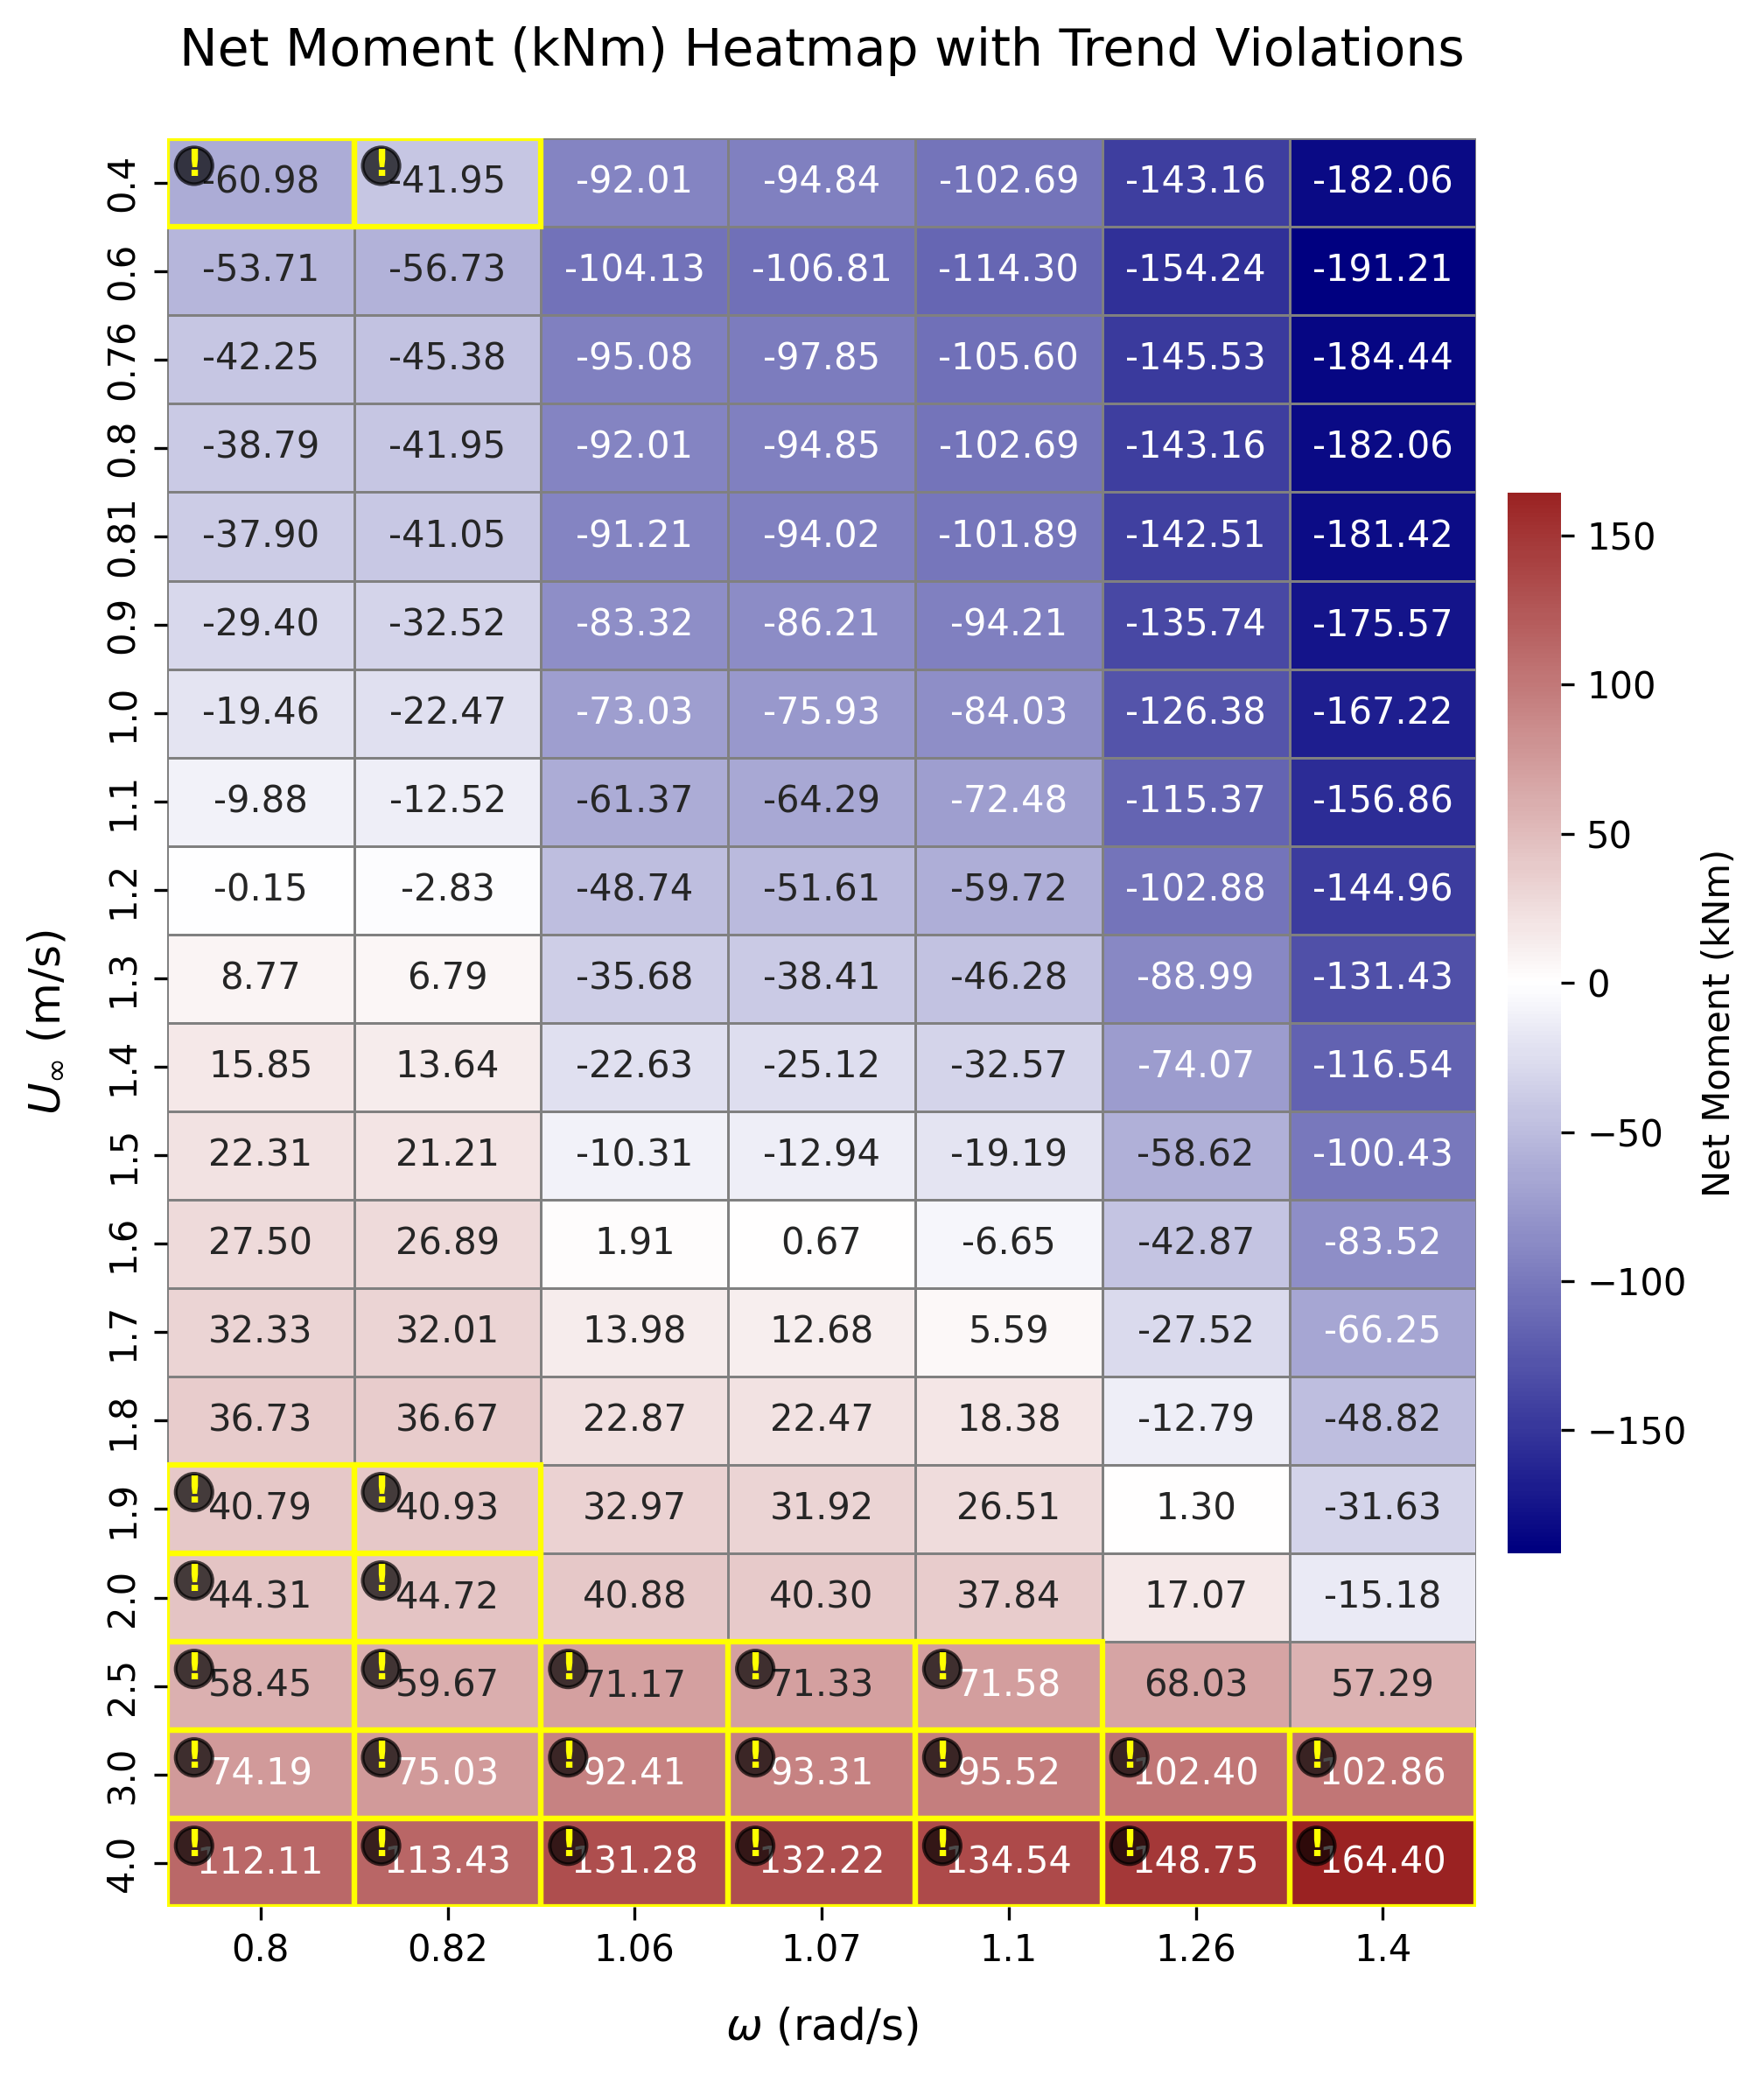

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap

# Adjust figure size and margins
plt.figure(figsize=(8, 8), dpi=300)
plt.subplots_adjust(left=0.2, right=0.85)  # Increase left margin, adjust right margin

# Create high-contrast colormap (more saturated colors)
#colors = ["#003366", "white", "#990000"]  # Deep blue and rich red
#cmap = LinearSegmentedColormap.from_list("high_contrast", colors)

# Create custom colormap with white at zero
colors = ["navy", "white", "darkred"]
cmap = LinearSegmentedColormap.from_list("custom_diverging", colors)
# Round the moment matrix to 2 decimal places
moment_matrix_rounded = np.round(moment_matrix, 2)
# Create heatmap with adjusted formatting
ax = sns.heatmap(moment_matrix_rounded, annot=True, fmt=".2f", cmap=cmap,
                center=0, linewidths=0.3, linecolor='gray',
                xticklabels=np.round(omega_list, 2),
                yticklabels=np.round(U0_list, 2),
                cbar_kws={'label': 'Net Moment (kNm)', 'shrink': 0.6, 'pad': 0.02},
                annot_kws={"size": 10})

# Axis labels and title
ax.set_xlabel("$ω$ (rad/s)", fontsize=12, labelpad=10)
ax.set_ylabel("$U_∞$ (m/s)", fontsize=12, labelpad=10)
ax.set_title("Net Moment (kNm) Heatmap with Trend Violations", pad=20, fontsize=14)

# Find and highlight violations
for i in range(moment_matrix.shape[0]):  # For each U0 (rows)
    violation_started = False
    for j in range(1, moment_matrix.shape[1]):  # For each ω (columns)

        if moment_matrix[i, j] > moment_matrix[i, j-1]:
            if not violation_started:
                # Mark the first violation
                ax.add_patch(Rectangle((j-1, i), 1, 1, fill=False,
                                     edgecolor='yellow', lw=1.5, linestyle='-'))
                violation_started = True
                # Add warning symbol to first violation
                ax.text(j-1+0.1, i+0.1, "!", ha="left", va="top",
                       color='yellow', fontsize=10, weight='bold',
                    bbox=dict(facecolor='black', alpha=0.7, pad=0, boxstyle='circle'))
            # Mark subsequent violations
            ax.add_patch(Rectangle((j, i), 1, 1, fill=False,
                                 edgecolor='yellow', lw=1.5, linestyle='-'))
            # Add smaller indicator for subsequent violations
            ax.text(j+0.1, i+0.1, "!", ha="left", va="top",
                   color='yellow', fontsize=10, weight='bold',
                    bbox=dict(facecolor='black', alpha=0.7, pad=0, boxstyle='circle'))

# Adjust colorbar position
cbar = ax.collections[0].colorbar
cbar.ax.set_position([0.88, 0.15, 0.03, 0.7])  # [left, bottom, width, height]

plt.tight_layout()
plt.show()

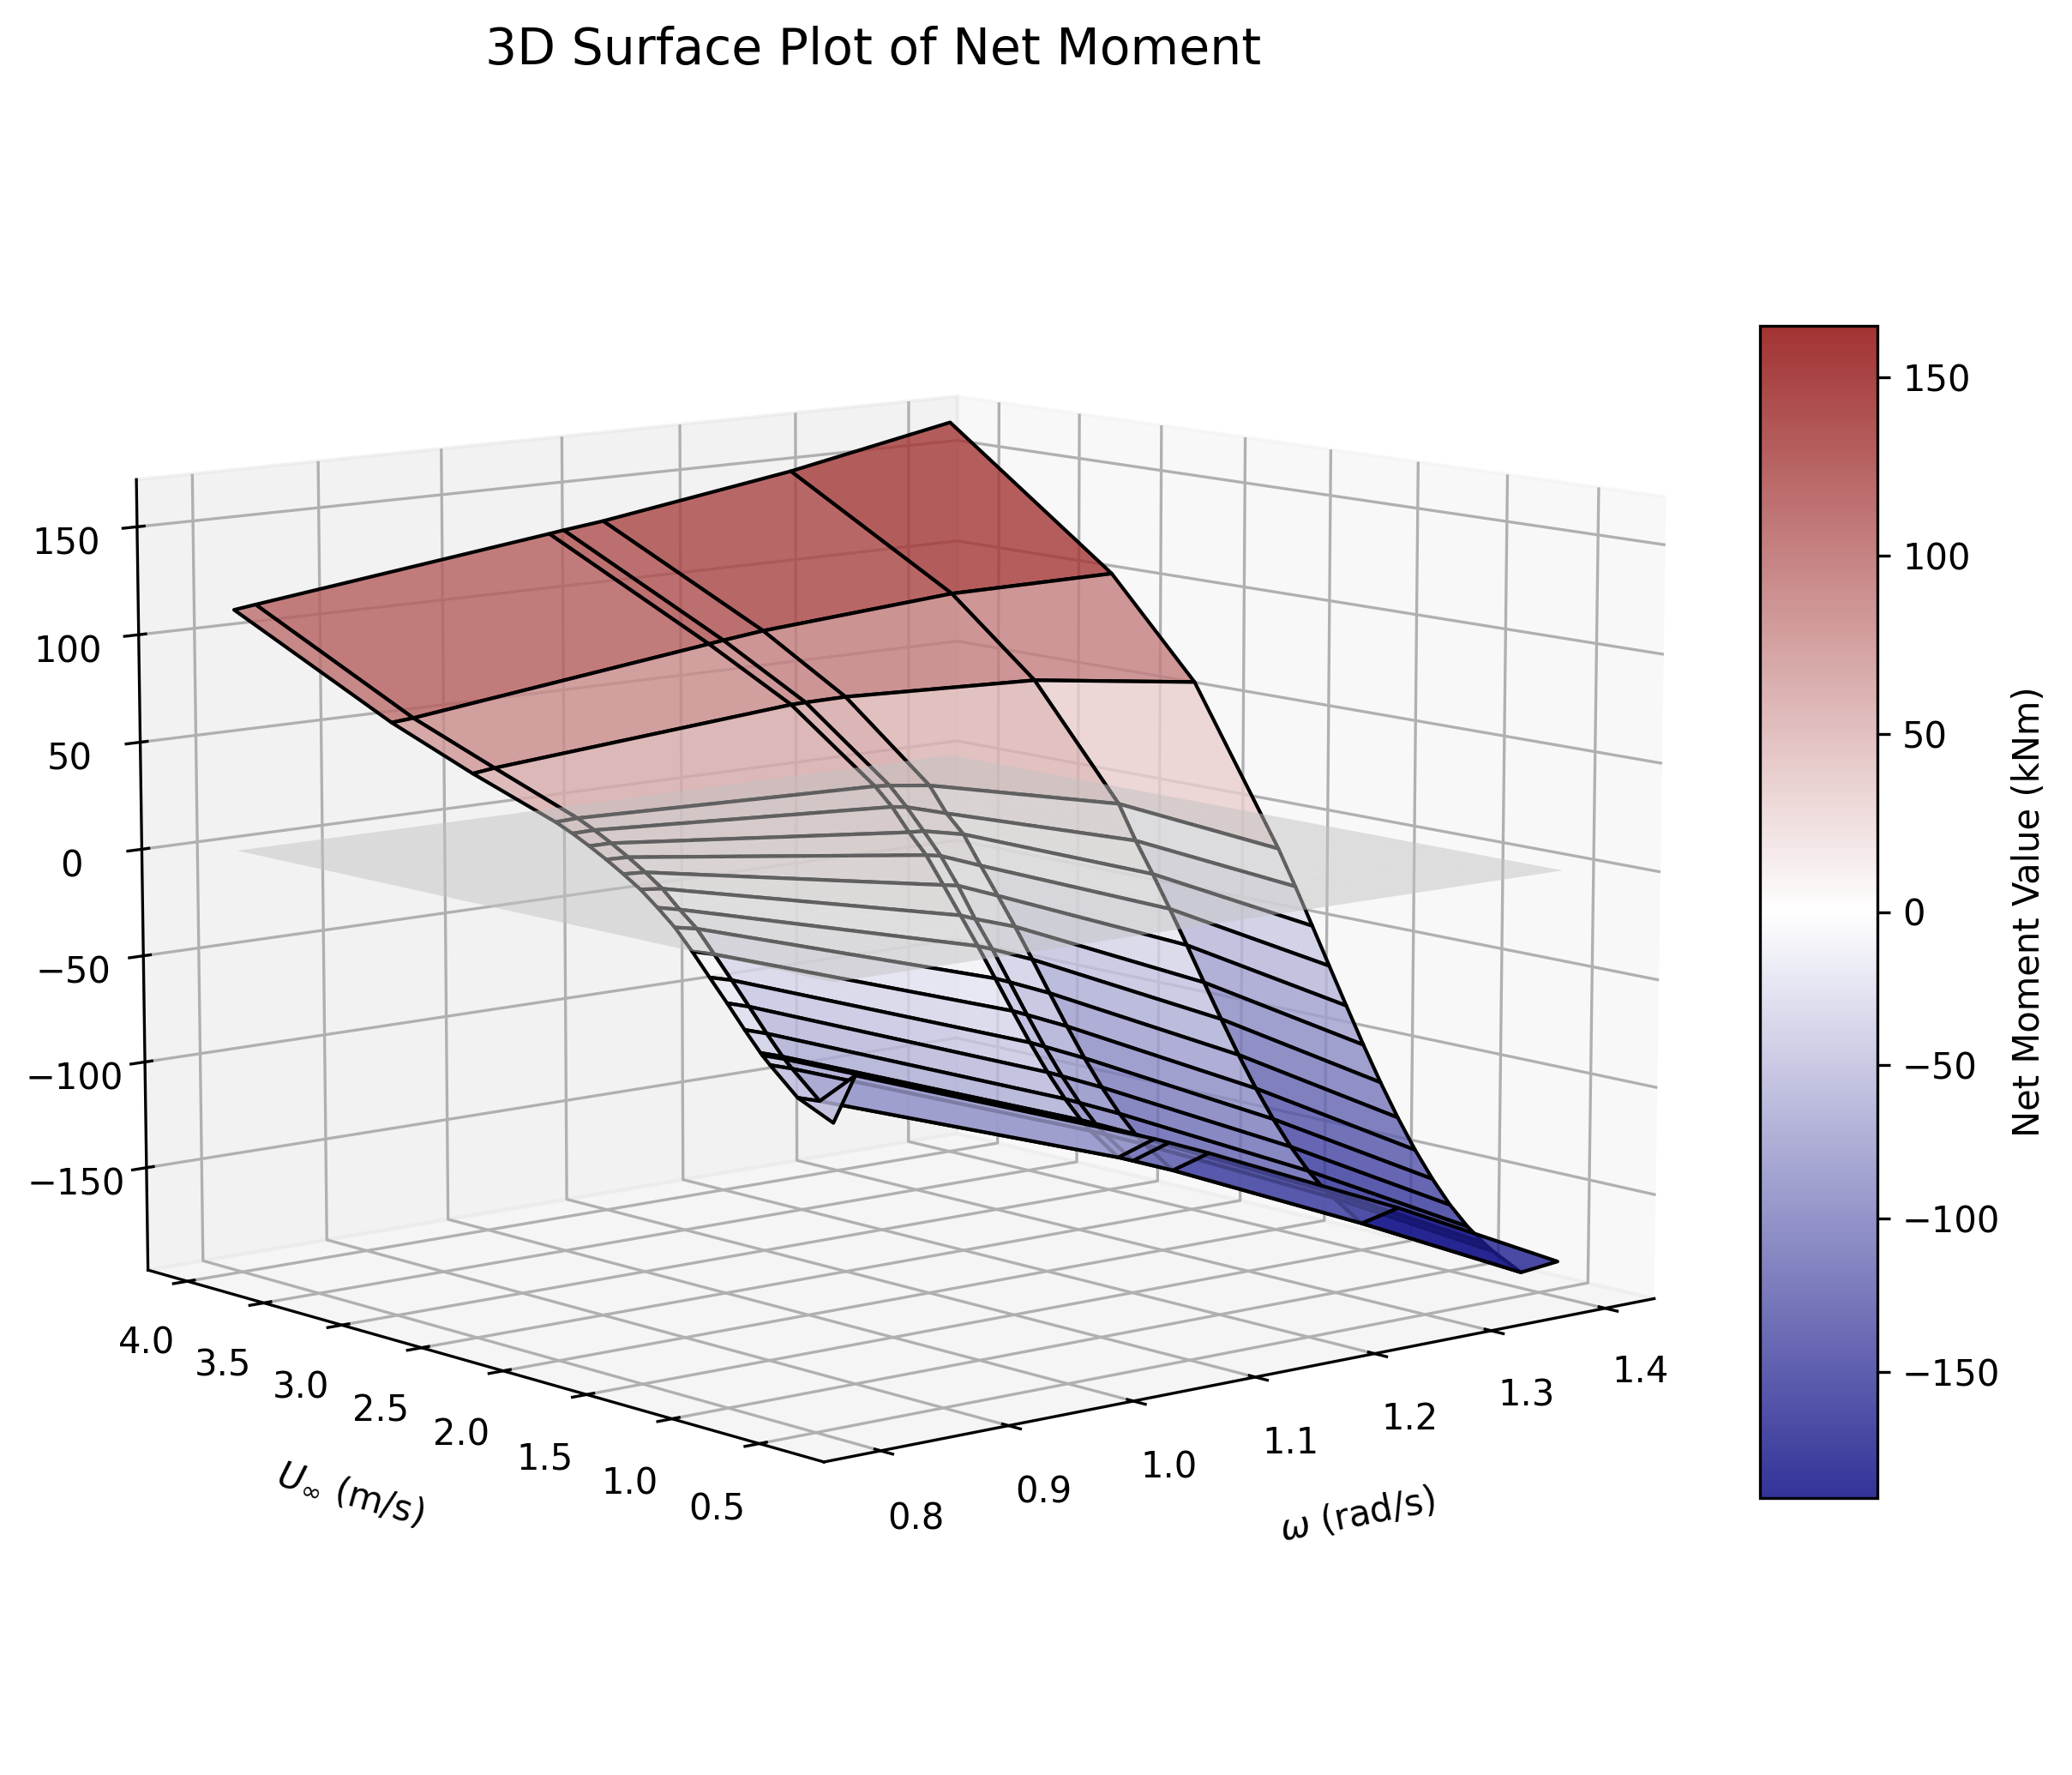

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from mpl_toolkits.mplot3d import Axes3D

R = 8.5
U0_list = np.array([0.4, 0.6, 0.756, 0.8, 0.81, 0.9, 1.0, 1.1, 1.2, 1.3,
                    1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.5, 3.0, 4.0])
omega_list = np.array([0.800, 0.817, 1.055, 1.067, 1.100, 1.260, 1.400])

U0_grid, omega_grid = np.meshgrid(U0_list, omega_list, indexing='ij')

colors = ["navy", "white", "darkred"]
cmap = LinearSegmentedColormap.from_list("custom_diverging", colors)
norm = TwoSlopeNorm(vmin=moment_matrix.min(), vcenter=0, vmax=moment_matrix.max())

fig = plt.figure(figsize=(10, 7), dpi=300)
ax = fig.add_subplot(111, projection="3d")

# 1) Exchange U0 and ω:
surf = ax.plot_surface(
    omega_grid,               # now ω on X
    U0_grid,                  # and U0 on Y
    moment_matrix,
    cmap=cmap,
    norm=norm,
    edgecolor="k",
    alpha=0.8
)

# 2) Exchange null-plane accordingly
omega_min, omega_max = omega_list.min(), omega_list.max()
U0_min, U0_max = U0_list.min(), U0_list.max()
omega_plane, U0_plane = np.meshgrid(
    np.linspace(omega_min, omega_max, 20),
    np.linspace(U0_min,  U0_max,  20)
)
zero_plane = np.zeros_like(omega_plane)
ax.plot_surface(
    omega_plane, U0_plane, zero_plane,
    color='white', alpha=0.5
)

ax.view_init(elev=10, azim=230)
ax.set_xlabel(r"$\omega$ (rad/s)", labelpad=12)
ax.set_ylabel(r"$U_∞$ (m/s)",   labelpad=12)
ax.set_zlabel("Net Moment (kNm)", labelpad=10)
ax.set_title("3D Surface Plot of Net Moment", pad=0, fontsize=14)

cbar = fig.colorbar(surf, ax=ax, shrink=0.7, aspect=10, pad=0.02)
cbar.set_label("Net Moment Value (kNm)", labelpad=3)

plt.tight_layout()
plt.show()

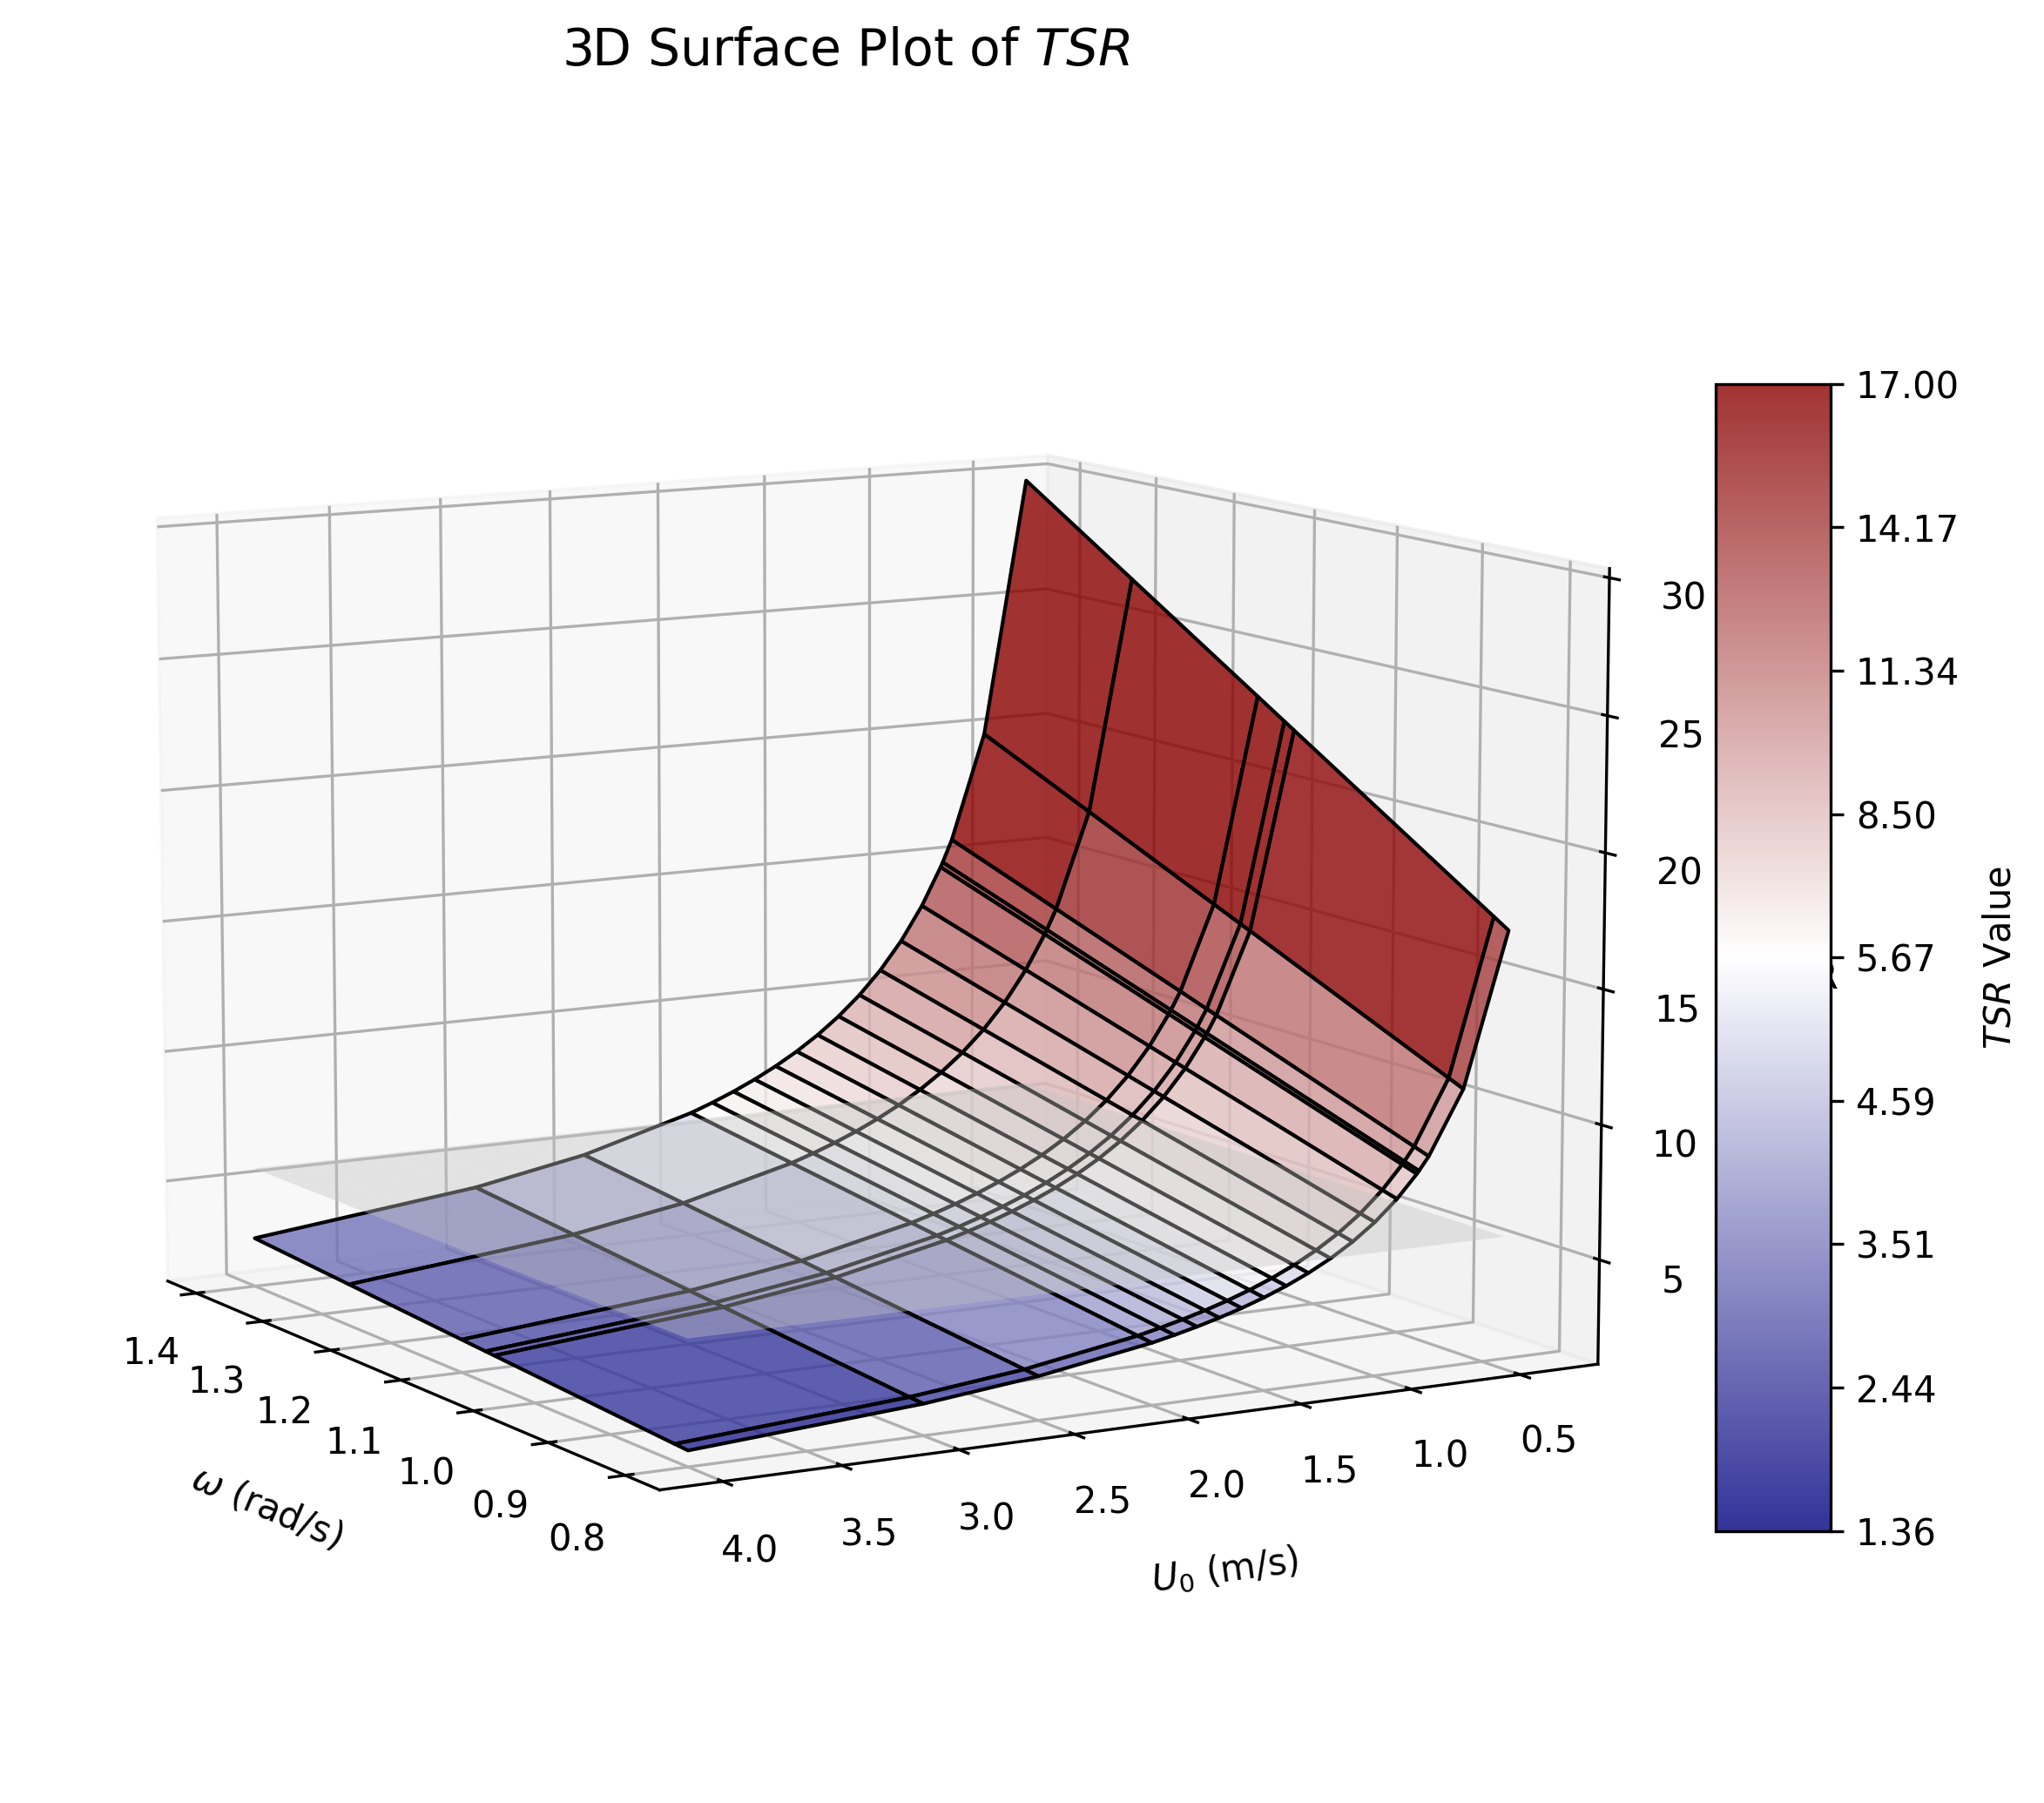

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from mpl_toolkits.mplot3d import Axes3D

R = 8.5
U0_list = np.array([0.4, 0.6, 0.756, 0.8, 0.81, 0.9, 1.0, 1.1, 1.2, 1.3,
                    1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.5, 3.0, 4.0])
omega_list = np.array([0.800, 0.817, 1.055, 1.067, 1.100, 1.260, 1.400])

U0_grid, omega_grid = np.meshgrid(U0_list, omega_list, indexing='ij')
TSR_grid = omega_grid * R / U0_grid  # TSR = ωR / U0

colors = ["navy", "white", "darkred"]
cmap = LinearSegmentedColormap.from_list("custom_tsr", colors)
norm = TwoSlopeNorm(vmin=1.36, vcenter=5.67, vmax=17.0)

fig = plt.figure(figsize=(10, 7), dpi=300)
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(
    omega_grid, U0_grid, TSR_grid,
    cmap=cmap,
    norm=norm,
    edgecolor="k",
    alpha=0.8
)

omega_plane, U0_plane = np.meshgrid(
    np.linspace(omega_list.min(), omega_list.max(), 20),
    np.linspace(U0_list.min(),  U0_list.max(),  20)
)
tsr_mid_plane = np.full_like(omega_plane, 5.67)
ax.plot_surface(
    omega_plane, U0_plane, tsr_mid_plane,
    color='white', alpha=0.4
)

ax.view_init(elev=50, azim=230)
ax.set_xlabel(r"$\omega$ (rad/s)", labelpad=12)
ax.set_ylabel(r"$U_0$ (m/s)", labelpad=12)
ax.set_zlabel("TSR", labelpad=10)
ax.set_title("3D Surface Plot of $TSR$", pad=20, fontsize=14)

cbar = fig.colorbar(surf, ax=ax, shrink=0.7, aspect=10, pad=0.02)
cbar.set_label("$TSR$ Value", labelpad=6)

ticks_upper = np.linspace(5.67, 17.0, 5)
ticks_lower = np.linspace(1.36, 5.67, 5)[:-1]
ticks = np.concatenate((ticks_lower, ticks_upper))
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{v:.2f}" for v in ticks])

ax.view_init(elev=10, azim=150)

plt.tight_layout()
plt.show()

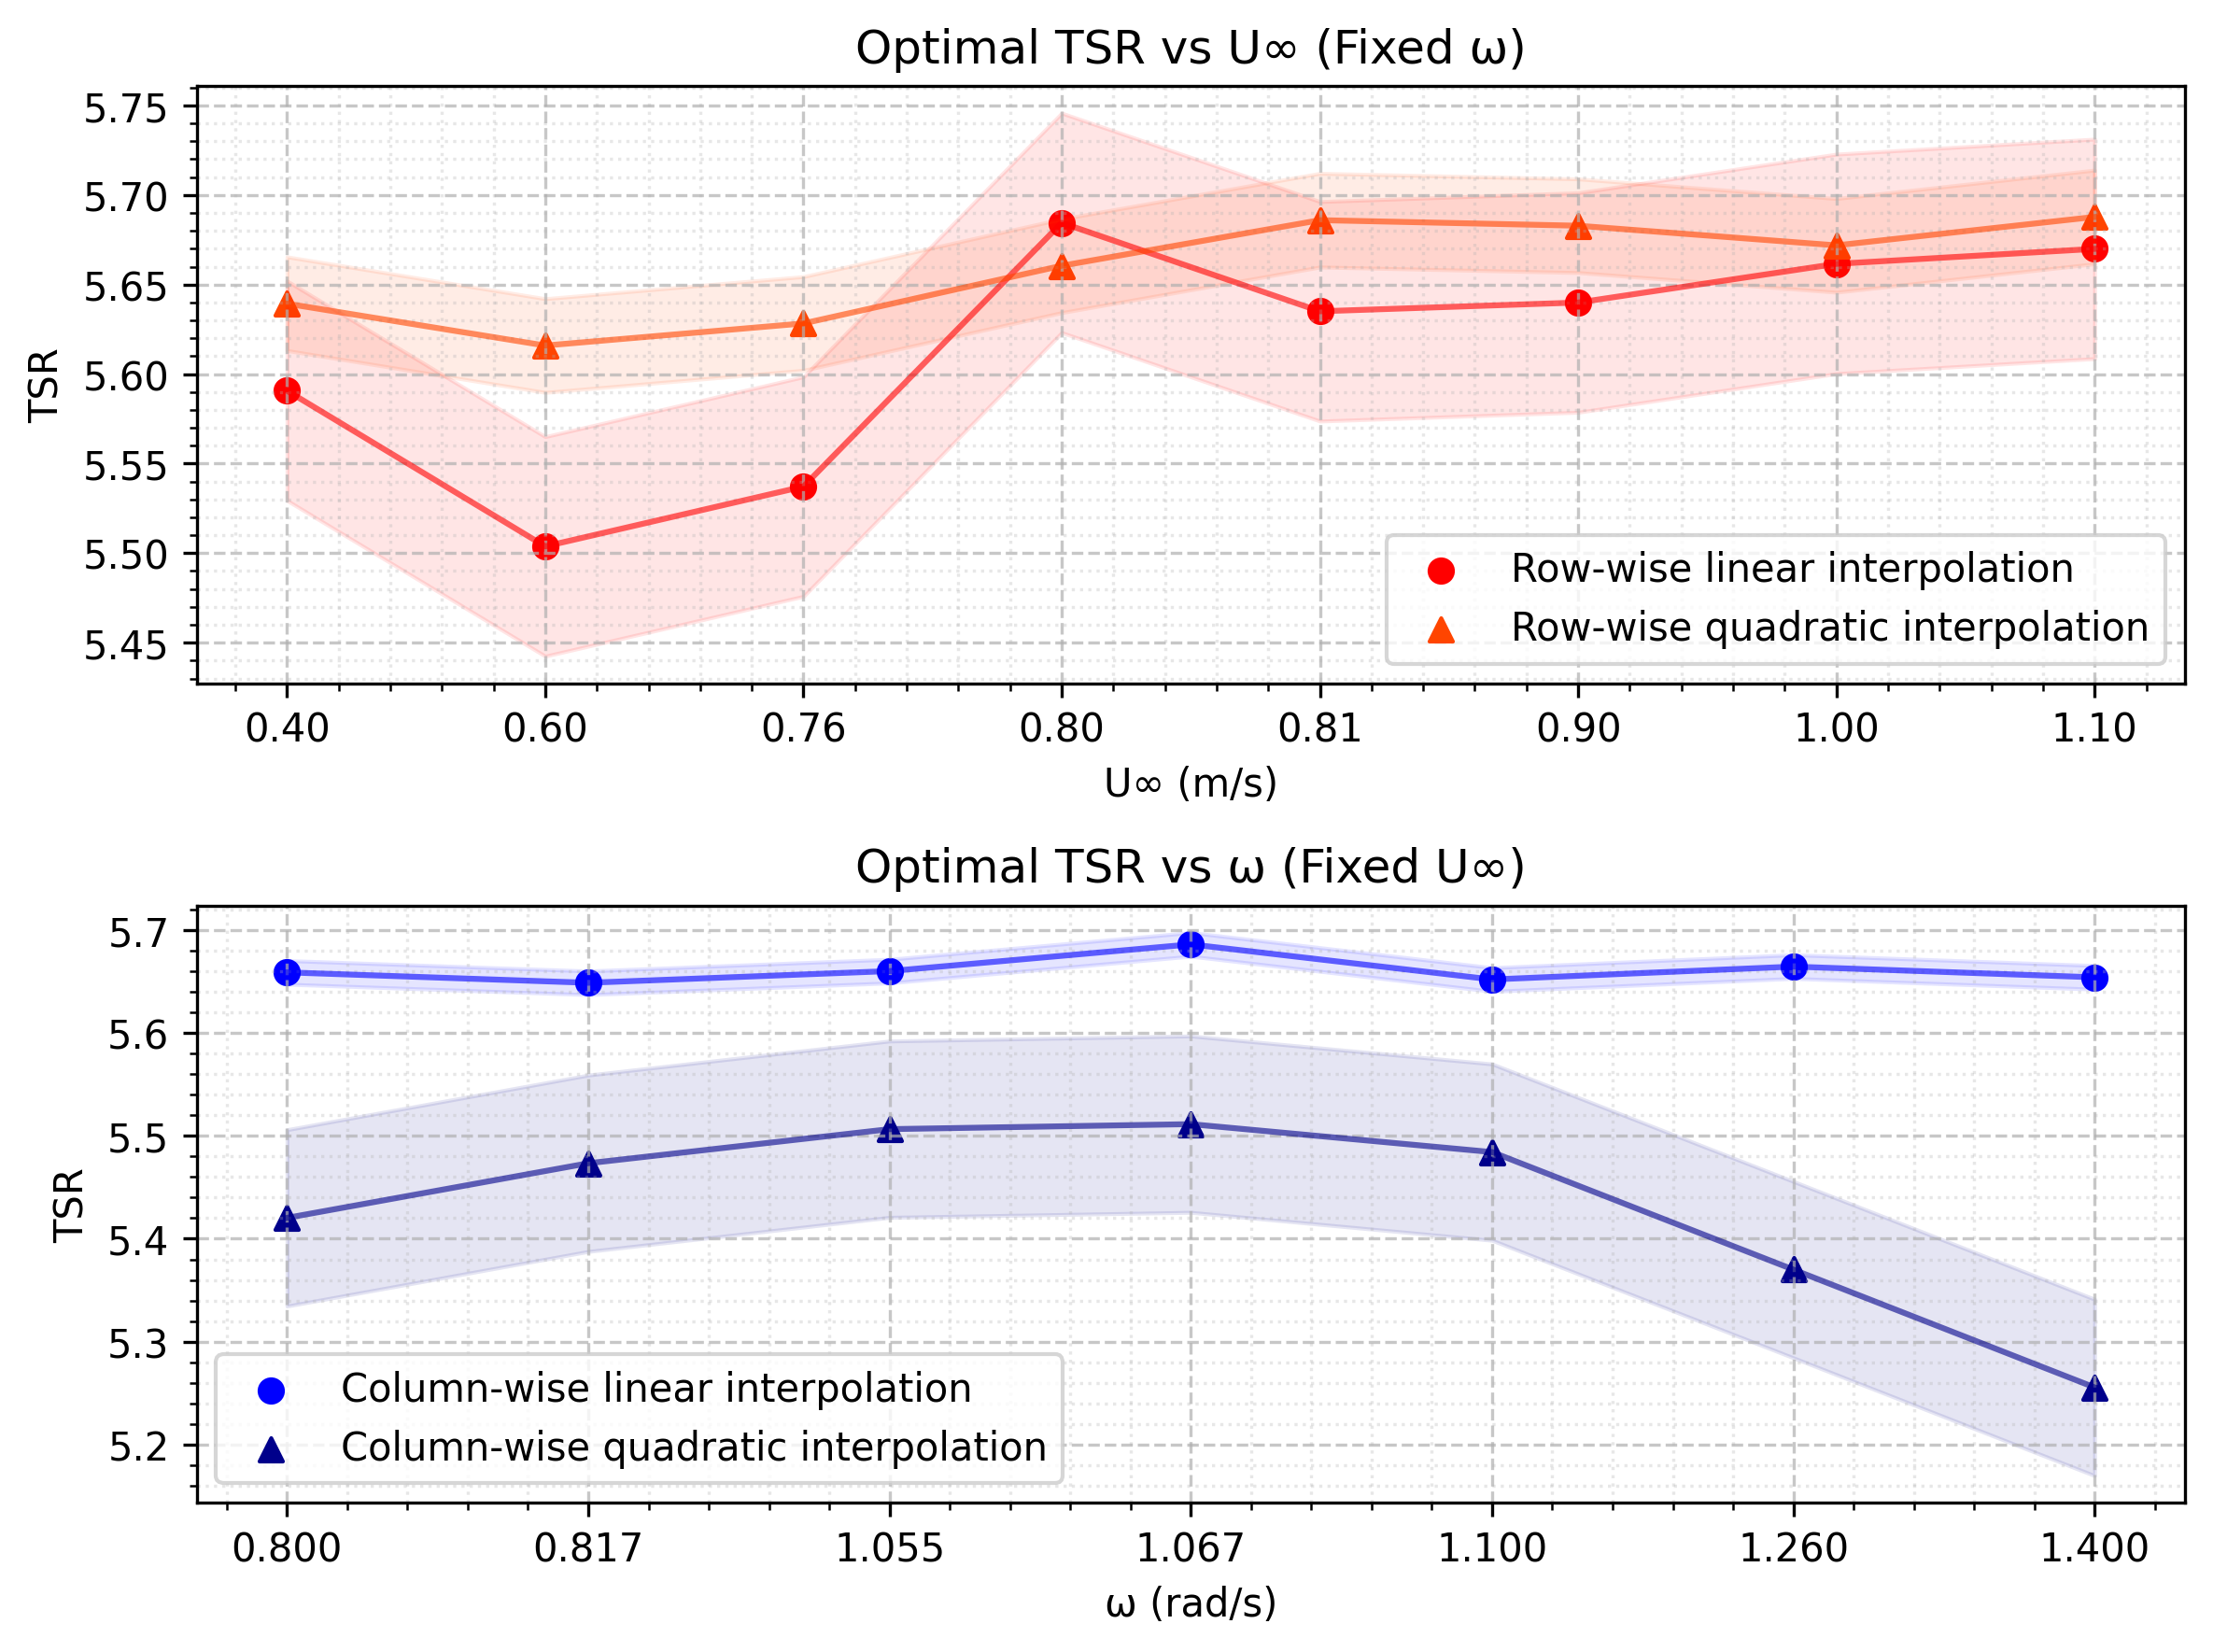

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6), dpi=300)

# ------------------------------
# Row-wise results (top subplot)
# ------------------------------
plt.subplot(2, 1, 1)

# Create x-axis labels from U0_list (keeping positions but showing U0 values)
x_row_positions = range(len(row_linear_TSRs))
x_row_labels = [f"{u:.2f}" for u in U0_list[:len(row_linear_TSRs)]]  # Use only needed values

# Plot linear interpolation results
plt.scatter(x_row_positions, row_linear_TSRs,
            marker='o', color='red', label="Row-wise linear interpolation")
plt.plot(x_row_positions, row_linear_TSRs,
         linestyle='-', color='red', alpha=0.6)

# Plot quadratic interpolation results
plt.scatter(x_row_positions, row_poly_TSRs,
            marker='^', color='orangered', label="Row-wise quadratic interpolation")
plt.plot(x_row_positions, row_poly_TSRs,
         linestyle='-', color='orangered', alpha=0.6)

# Add std deviation bands
plt.fill_between(x_row_positions,
                 np.array(row_linear_TSRs) - row_linear_std,
                 np.array(row_linear_TSRs) + row_linear_std,
                 color='red', alpha=0.1)

plt.fill_between(x_row_positions,
                 np.array(row_poly_TSRs) - row_poly_std,
                 np.array(row_poly_TSRs) + row_poly_std,
                 color='orangered', alpha=0.1)

# Formatting
plt.title('Optimal TSR vs U∞ (Fixed ω)')
plt.xlabel('U∞ (m/s)')
plt.ylabel('TSR')
plt.xticks(x_row_positions, x_row_labels)  # Set custom x-tick labels
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Add minor ticks
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', alpha=0.3)

# ------------------------------
# Column-wise results (bottom subplot)
# ------------------------------
plt.subplot(2, 1, 2)

# Create x-axis labels from omega_list (keeping positions but showing ω values)
x_col_positions = range(len(col_linear_TSRs))
x_col_labels = [f"{w:.3f}" for w in omega_list[:len(col_linear_TSRs)]]  # Use only needed values

# Plot linear interpolation results
plt.scatter(x_col_positions, col_linear_TSRs,
            marker='o', color='blue', label="Column-wise linear interpolation")
plt.plot(x_col_positions, col_linear_TSRs,
         linestyle='-', color='blue', alpha=0.6)

# Plot quadratic interpolation results
plt.scatter(x_col_positions, col_poly_TSRs,
            marker='^', color='darkblue', label="Column-wise quadratic interpolation")
plt.plot(x_col_positions, col_poly_TSRs,
         linestyle='-', color='darkblue', alpha=0.6)

# Add std deviation bands
plt.fill_between(x_col_positions,
                 np.array(col_linear_TSRs) - col_linear_std,
                 np.array(col_linear_TSRs) + col_linear_std,
                 color='blue', alpha=0.1)

plt.fill_between(x_col_positions,
                 np.array(col_poly_TSRs) - col_poly_std,
                 np.array(col_poly_TSRs) + col_poly_std,
                 color='darkblue', alpha=0.1)

# Formatting
plt.title('Optimal TSR vs ω (Fixed U∞)')
plt.xlabel('ω (rad/s)')
plt.ylabel('TSR')
plt.xticks(x_col_positions, x_col_labels)  # Set custom x-tick labels
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Add minor ticks
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', alpha=0.3)

plt.tight_layout()
plt.show()